<a href="https://colab.research.google.com/github/phoenixfin/deeplearning-notebooks/blob/main/rps_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Paper Scissor Classification

### Aditya Firman Ihsan
#### aditya.fphoenix@gmail.com

1. Unduh dulu datasetnya dari link yang disediakan

In [ ]:
!wget --no-check-certificate \
    https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip

--2020-09-17 22:31:00--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip’

rockpaperscissors.z 100%[===================>] 307.92M  6.11MB/s    in 43s     

2020-09-17 22:31:44 (7.10 MB/s) - ‘rockpaperscissors.zip’ saved [322873683/322873683]



2. Import semua package yang dibutuhkan

In [ ]:
# untuk mengolah file dataset
import os
import zipfile
import random
import shutil

# untuk modelling
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator

# untuk mengolah gambar prediksi
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt


3. Extract dataset dari file .zip yang sudah diunduh

In [ ]:
local_zip = '/content/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# hapus folder redudndant yang berisi data dobel
!rm -r '/content/rockpaperscissors/rps-cv-images'


Mengecek isi dataset dulu

In [ ]:
rock_dir = os.path.join('/content/rockpaperscissors/rock')
rock_files = os.listdir(rock_dir)
paper_dir = os.path.join('/content/rockpaperscissors/paper')
paper_files = os.listdir(paper_dir)
scissors_dir = os.path.join('/content/rockpaperscissors/scissors')
scissors_files = os.listdir(scissors_dir)

print('total gambar batu:', len(os.listdir(rock_dir)))
print('total gambar kertas:', len(os.listdir(paper_dir)))
print('total gambar gunting:', len(os.listdir(scissors_dir)))

total gambar batu: 726
total gambar kertas: 712
total gambar gunting: 750


4. Memisahkan dataset menjadi training data dan validation data dengan ratio 6:4

In [ ]:
def create_data_dir(target_dir, subdirs):
    """
    membuat struktur dataset
    """
    def trymakedir(sdir):
        try:
            os.mkdir(sdir)
        except:
            pass
    try:
        trymakedir(target_dir)
        subdir1 = ['train','validation']
        subdir2 = subdirs
        for sd1 in subdir1:
            trymakedir(target_dir+'/'+sd1)
            for sd2 in subdir2:
                subpath = target_dir+'/'+sd1+'/'+sd2
                trymakedir(subpath)
                for file in os.listdir(subpath):
                    os.remove(subpath+'/'+file)
    except OSError:
        pass

def split_data(source, train, validation, split_size):
    """
    memindahkan data gambar sesuai dengan porsinya
    """
    source_list = os.listdir(source)
    randomized = random.sample(source_list, len(source_list))
    filtered = [file for file in randomized if (os.path.getsize(source+file)!=0) ]
    training_num = round(len(filtered)*split_size)    
    for idx, img in enumerate(filtered):
        if idx < training_num:
            shutil.copyfile(source+img, train+img)
        else:
            shutil.copyfile(source+img, validation+img)

def arrange_data(source, category, ratio):
    """
    mengatur ulang dataset dari sumber yang di download agar siap 
    untuk masuk model
    """
    base_dir = '/content/dataset/'
    create_data_dir(base_dir, category)

    for cat in category:
        source_dir = source + '/' + cat + '/'
        train_dir = base_dir + '/train/' + cat + '/' 
        validation_dir = base_dir + '/validation/' + cat + '/'
        split_data(source_dir, train_dir, validation_dir, split_size=ratio)      

Saatnya memanggil fungsi di atas

In [ ]:
data_dir = '/content/rockpaperscissors'

# di-list dulu ada kategori apa saja untuk label gambarnya
category = []
for item in os.listdir(data_dir):
    if os.path.isdir(data_dir+'/'+item):
        category.append(item)
arrange_data(data_dir, category, 0.6)

5. Membuat generator untuk dataset tersebut

In [ ]:
TRAINING_DIR = "/content/dataset/train"
VALIDATION_DIR = "/content/dataset/validation"

# Pakai augmentasi untuk menghindari overfitting
train_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

val_datagen = ImageDataGenerator(
      rescale = 1./255
)

val_generator = val_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

Found 1313 images belonging to 3 classes.
Found 875 images belonging to 3 classes.


6. Membangun model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

7. Jalankan modelnya pada dataset

In [ ]:
model.fit(train_generator, epochs=15, validation_data=val_generator, verbose = 1)

Epoch 1/15
42/42 [==============================] - 10s 244ms/step - loss: 1.4062 - accuracy: 0.3739 - val_loss: 1.0139 - val_accuracy: 0.4599
Epoch 2/15
42/42 [==============================] - 10s 241ms/step - loss: 1.0754 - accuracy: 0.4757 - val_loss: 0.7646 - val_accuracy: 0.8096
Epoch 3/15
42/42 [==============================] - 10s 240ms/step - loss: 0.7989 - accuracy: 0.6406 - val_loss: 0.4117 - val_accuracy: 0.9140
Epoch 4/15
42/42 [==============================] - 10s 240ms/step - loss: 0.6984 - accuracy: 0.7044 - val_loss: 0.3176 - val_accuracy: 0.9415
Epoch 5/15
42/42 [==============================] - 10s 240ms/step - loss: 0.6272 - accuracy: 0.7439 - val_loss: 0.4285 - val_accuracy: 0.8567
Epoch 6/15
42/42 [==============================] - 10s 239ms/step - loss: 0.5372 - accuracy: 0.7926 - val_loss: 0.1733 - val_accuracy: 0.9667
Epoch 7/15
42/42 [==============================] - 10s 238ms/step - loss: 0.4737 - accuracy: 0.8153 - val_loss: 0.1290 - val_accuracy: 0.9794

8. Tes model dengan gambar baru

Saving testpaper01-06.png to testpaper01-06.png
testpaper01-06.png
paper


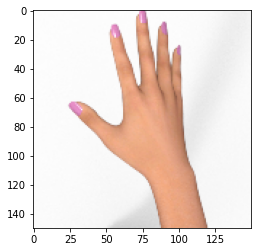

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys(): 
    # predicting images
    path = fn
    img = image.load_img(path, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255.
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(fn)
    print(category[np.argmax(classes[0])])